In [763]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from scipy.spatial.distance import pdist, squareform
import timeit

In [764]:
def getdata(filename):
    """ Fetches the Data from the .DAT file and convert it into np arrays"""   
    return np.genfromtxt(filename,delimiter=" ",dtype='float')

points = getdata('svar-set1.dat') 

##Implict Solution to find Theta

Single Feature Linear Model
    $ \theta = (Z^TZ)^{-1}Y $

Single Feature Polynomial Model
    $ \theta = (Z^TZ)^{-1}Z^TY $

Multiple Features 
    $ \theta = (Z^TZ)^{-1}Z^TY $


In [765]:
def fit(X,Y,mtype="poly"):
    """ This function compute Thetas based on the type of the model """
    sumation=0
    if(len(X)!=len(Y)):
        return -1
    
    if(mtype=="Single"):
    
        for i in range(0,len(X)):
                sumation +=X[i]*Y[i]

        Y_s = np.array([Y.sum(),sumation])
        
        Zs = np.array(X)
        ones = np.ones(len(Zs))
        Zs = np.concatenate((ones.reshape(len(ones),1),Zs.reshape(len(Zs),1)),axis=1 )  
        thetas = np.linalg.solve(np.dot(Zs.transpose(),Zs),Y_s)
    else:
        Z= X
        thetas = np.dot(np.linalg.pinv(Z),Y)
            
    return thetas

<i><b>Z</b></i> represents the mapping of Vectors from Smaller dimension to Higher Dimension space

Eg. $ [  X_1 , X_2 ] $ can be mapped to higher degrees like $ [ 1, X_1, X_2 ,X_1^2 ,X_2^2, X_1X_2.....] $

$Z = [1 , X_1 , X_2 ....... X_N]^ p $

In [766]:
def X_to_Z(x,power):
    """The Feature Vector matrix is mapped to any specified Degree  """
    poly = PolynomialFeatures(power)
    Z = poly.fit_transform(x.reshape(len(x),x[1].size))
    return Z

##Prediction using Linear Model 

##$\hat{y^i} = \theta_0 + X^i\cdot {\theta_1}$
For better computability the same formula can be re-written as,
## $ \hat{y} = \theta_0^T \cdot Z$

In [767]:
def predict(theta, X):
    """ Prediction is done using Linear model with single feature Y = Theta_O + Thet_1.X"""
    return np.dot(theta,X.transpose())



In [797]:
def KFold(length,folds):
    """ Support function to give the KFOLD indices to be used during Cross Validation"""
    n = int(length/folds)
    
    x=0
    cv=[]
    while( x*n<length  ):
       
        test = range(x*n,(x*n)+n)
        train = [i for i in range(0,length) if i not in test]
        cv.append((train,test))
                  
        x=x+1
    return cv

KFold(10,2)    

[([5, 6, 7, 8, 9], [0, 1, 2, 3, 4]), ([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])]

In [769]:
def do_cross_Validation(X,y,n_folds=10,mtype="Single"):
    cv = KFold(len(y), n_folds)
    accuracies = []
    index=0
    for train_idx, test_idx in cv:
        cv_theta = fit(X[train_idx],y[train_idx],mtype)
        if(mtype=="Single"): 
            Zs = X_to_Z(X[test_idx],1)
        else:
            Zs = X[test_idx]
        cv_y_cap = predict(cv_theta,Zs)
        mse=mean_squared_error(y[test_idx],cv_y_cap)
       
        index = index +1
        accuracies.append(mse)
    return np.mean(accuracies)


print "Cross Validation error with 10 folds",do_cross_Validation(X_Train ,Y_Train ,n_folds=10)

Cross Validation error with 10 folds 4.38419193846


####First 150 Rows of the Data Set is taken as Trainning Samples and the rest 100 is used for Testing the Linear Model

In [770]:
def get_split(points,split):
    X_Train  = points[:split,0]
    Y_Train = points[:split,1]
    thetas = fit(X_Train ,Y_Train,mtype="Single")


    print "Theta 0 and Theta 1", thetas
    X_Test = points[split:,0]
    Y_Test = points[split:,1]
    return X_Train,Y_Train,thetas,X_Test,Y_Test

X_Train,Y_Train,thetas,X_Test,Y_Test= get_split(points,150)

Theta 0 and Theta 1 [ 0.34886358  1.97811066]


In [771]:
def mean_squared_error(y,y_cap):
    """ Computes the mean squared Error"""
    errors = 0
    for i in range(0,len(y)):        
        errors = errors + (y_cap[i] -y[i])**2
        
    return errors.sum()/len(y)



In [772]:
def Residual_Sum_Square(y,y_cap):
    """Computes the residual sum of squares error """
    errors = 0
    for i in range(0,len(y)):        
        errors = errors + (y_cap[i] -y[i])**2
        
    return errors.sum()


In [773]:
start_time = timeit.default_timer()
Zs = X_to_Z(X_Test,1)

Y_Cap = predict(thetas,Zs)
end_time = timeit.default_timer()

single_time  = end_time - start_time
print "Mean Squared Errors",mean_squared_error(Y_Test,Y_Cap)
print "Residual Sum of Square",Residual_Sum_Square(Y_Test,Y_Cap)
print "Time Taken",single_time

Mean Squared Errors 4.29856341131
Residual Sum of Square 214.928170566
Time Taken 0.000631217015325


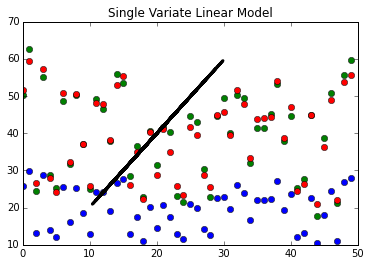

In [774]:
def plot_models(X,y,y_cap,title):
    plt.plot(X,'o')
    plt.plot(y,'o')
    plt.plot(y_cap,'o')
    plt.plot(X,y_cap, color='Black',linewidth=3)
    plt.title(title)

    plt.show()
    
plot_models(X_Test,Y_Test,Y_Cap,"Single Variate Linear Model ")

In [775]:
def Hypothesis_error(Y_Cap,Y):
    return np.var(Y_Cap) + ((Y_Cap - np.mean(Y)).sum()**2)  
print Hypothesis_error(Y_Cap,Y_Test)

331.673310427


##Comparision between the Linear Regression Implementation and Scikit.learn's Linear Model





In [776]:
from sklearn import linear_model
def compare(X_Train,Y_Train,X_Test,Y_Test):
    """ Uses Scikit Learn's LinearRegression Function  """
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_Train.reshape(-1, 1) , Y_Train)
    y_cap = regr.predict(X_Test.reshape(-1, 1))
    print "By Scikit Learn Mean Squared Error: ",mean_squared_error(Y_Test,y_cap)
    
start_time = timeit.default_timer()   
compare(X_Train,Y_Train,X_Test,Y_Test)
end_time = timeit.default_timer()
print "Time Taken by Scikit Learn", end_time - start_time

print "By implemented Model Mean Square Error",mean_squared_error(Y_Test,Y_Cap) 
print "Time Taken by Implemented model", single_time 

By Scikit Learn Mean Squared Error:  4.29856341131
Time Taken by Scikit Learn 0.00227554589947
By implemented Model Mean Square Error 4.29856341131
Time Taken by Implemented model 0.000631217015325


##Single Variable - Polynomial Models
$H_\theta(X) = [ \theta_0 ,\theta_1 X_1 ,\theta_2 X_1^2...,\theta_n X_1^n] $

"An Experiment is conducted to identify the degree of the polynomial functions that needs to be used,
We try different degrees from 1 to 5 and find the Training and Test Error. We take both Training and Testing errors into consideration 
in order eliminate the scenario of overfitting models
"

In [777]:
def do_experiment(X_Train,Y_Train,X_Test,Y_Test):
    """Experiment to find a suitable degree for the polynomial function """
    for i in range(1,10):
        Z_Train= X_to_Z(X_Train,i)
        mtheta = fit(Z_Train,Y_Train,mtype="Poly")
        mutli_Y_cap = predict(mtheta,Z_Train)

        Z= X_to_Z(X_Test,i)
        mutli_Y_cap_Test = predict(mtheta,Z)
        
        print "For i = ",i, "Training CV Error", do_cross_Validation(Z_Train,Y_Train,mtype="Poly"),"Test Error", mean_squared_error(Y_Test,mutli_Y_cap_Test)

In [778]:
newDataset =  getdata('svar-set2.dat') 
newX_Train,newY_Train,newthetas,newX_Test,newY_Test= get_split(newDataset,150)


Theta 0 and Theta 1 [ 0.32615745 -0.07842592]


In [779]:
print "Experiment with Data Set 2 for Polynimial Models \n"

do_experiment(newX_Train,newY_Train,newX_Test,newY_Test)

Experiment with Data Set 2 for Polynimial Models 

For i =  1 Training CV Error 0.0660335791579 Test Error 0.0531134130605
For i =  2 Training CV Error 0.0442174066593 Test Error 0.0313576616778
For i =  3 Training CV Error 0.0225341938361 Test Error 0.0189648710986
For i =  4 Training CV Error 0.0128264038913 Test Error 0.0108183022908
For i =  5 Training CV Error 0.0130853837141 Test Error 0.00994812717478
For i =  6 Training CV Error 0.0127727542082 Test Error 0.0107762502099
For i =  7 Training CV Error 0.00685007868802 Test Error 0.00815474533125
For i =  8 Training CV Error 0.00441805089575 Test Error 0.00546164801546
For i =  9 Training CV Error 0.0040409115774 Test Error 0.00454183615993


In [780]:
print "Experiment with Data Set 1 for Polynimial Models \n"

do_experiment(X_Train,Y_Train,X_Test,Y_Test)

Experiment with Data Set 1 for Polynimial Models 

For i =  1 Training CV Error 4.38419193846 Test Error 4.29856341131
For i =  2 Training CV Error 4.43687922999 Test Error 4.34355934721
For i =  3 Training CV Error 4.49829478324 Test Error 4.21425175253
For i =  4 Training CV Error 4.5128074272 Test Error 4.17825535149
For i =  5 Training CV Error 4.56445239708 Test Error 4.17958158238
For i =  6 Training CV Error 4.42132648852 Test Error 4.24161652809
For i =  7 Training CV Error 4.47729185832 Test Error 4.23941757661
For i =  8 Training CV Error 4.50407572994 Test Error 4.2563135219
For i =  9 Training CV Error 4.55680027476 Test Error 4.26733904806


>For degree= 4 Training Error is 4.5128074272 Testing Error is 4.17825535149

From the above experiment we can see that the Hypothesis Error is the minimum for Degree = 4

Mean Squared Error using Single Feature Polynomial Model :  4.17825535149
Residual Sum Square Error using Single Feature Polynomial Model :  208.912767574


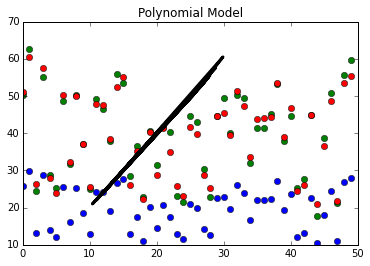

In [782]:
def do_poly_fit_predict(X_Train,Y_Train,X_Test,Y_Test,power=4):
    Z_Poly= X_to_Z(X_Train,power)

    theta_Poly = fit(Z_Poly,Y_Train,mtype="Poly")

    Z_Test_Poly = X_to_Z(X_Test,4)
    Y_Cap_Poly = predict(theta_Poly,Z_Test_Poly)

    print "Mean Squared Error using Single Feature Polynomial Model : " , mean_squared_error(Y_Test,Y_Cap_Poly)
   
    print "Residual Sum Square Error using Single Feature Polynomial Model : " ,  Residual_Sum_Square(Y_Test,Y_Cap_Poly)
    plot_models(X_Test,Y_Test,Y_Cap_Poly,"Polynomial Model")

do_poly_fit_predict(X_Train,Y_Train,X_Test,Y_Test,power=4)

##Comparision by reducing the Training Data Samples



Cross Validation Error 	3.48817406709
Mean Squared Error using Single Feature Polynomial Model :  4.7143245382
Residual Sum Square Error using Single Feature Polynomial Model :  235.71622691


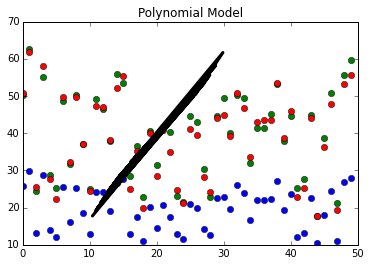

Cross Validation Error 	4.4625102951
Mean Squared Error using Single Feature Polynomial Model :  4.22036800272
Residual Sum Square Error using Single Feature Polynomial Model :  211.018400136


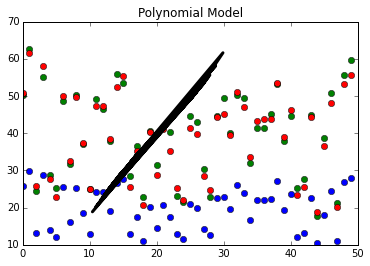

Cross Validation Error 	4.33717965673
Mean Squared Error using Single Feature Polynomial Model :  4.0915578955
Residual Sum Square Error using Single Feature Polynomial Model :  204.577894775


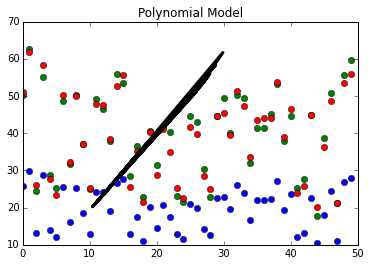

Cross Validation Error 	4.28240617368
Mean Squared Error using Single Feature Polynomial Model :  4.00421077043
Residual Sum Square Error using Single Feature Polynomial Model :  200.210538522


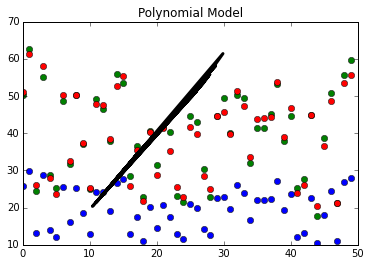

Cross Validation Error 	4.38419193846
Mean Squared Error using Single Feature Polynomial Model :  4.17825535149
Residual Sum Square Error using Single Feature Polynomial Model :  208.912767574


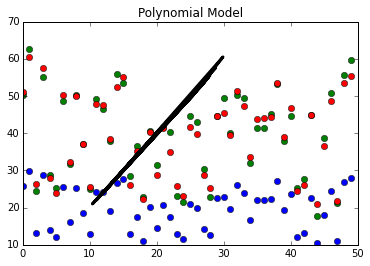

In [783]:
for size in [50,80,100,120,150]: 
    print "Cross Validation Error \t", do_cross_Validation(X_Train[:size] ,Y_Train[:size] ,n_folds=10)
    do_poly_fit_predict(X_Train[:size],Y_Train[:size],X_Test,Y_Test)
    
    

## Multivariate Regression

In [784]:
#get Data from Dataset
multipoints = getdata('mvar-set1.dat')


In [785]:
# get X matrix and Z matri
X = np.delete(multipoints,2,1)
Y = multipoints[:,2]
mX_Train = X[:1500]
mY_Train = Y[:1500]
mX_Test = X[1500:]
mY_Test = Y[1500:]

mZ= X_to_Z(mX_Train,2)
print "Mapping X to Higer Dimension '2' Results in ", mZ.shape

mZ= X_to_Z(mX_Train,3)
print "Mapping X to Higer Dimension '3' Results in ", mZ.shape

mZ= X_to_Z(mX_Train,4)
print "Mapping X to Higer Dimension '4' Results in ", mZ.shape

Mapping X to Higer Dimension '2' Results in  (1500L, 6L)
Mapping X to Higer Dimension '3' Results in  (1500L, 10L)
Mapping X to Higer Dimension '4' Results in  (1500L, 15L)


##Prediction using Multi Variate Linear Model 

##$\hat{y^i} = \theta_0 + X^i_1\cdot {\theta_1} + X^i_2\cdot {\theta_2}$ 
$\theta^T \cdot Z $

In [786]:
do_experiment(mX_Train,mY_Train,mX_Test,mY_Test)

For i =  1 Training CV Error 0.259956250375 Test Error 0.258224010988
For i =  2 Training CV Error 0.261044149799 Test Error 0.25776193971
For i =  3 Training CV Error 0.263784664564 Test Error 0.257318222473
For i =  4 Training CV Error 0.26476956965 Test Error 0.256139174876
For i =  5 Training CV Error 0.267055630264 Test Error 0.258054006786
For i =  6 Training CV Error 0.267519335005 Test Error 0.260749621246
For i =  7 Training CV Error 0.269367296557 Test Error 0.261574692624
For i =  8 Training CV Error 0.271184639754 Test Error 0.265004966613
For i =  9 Training CV Error 0.273559623058 Test Error 0.265320339969


>For i =  4 Training Error 0.26476956965 Test Error 0.256361459492
It is better to choose Degree = 4 by considering the trade-off between the Bias-Variance.

In [787]:
mZ= X_to_Z(mX_Train,4)
mtheta = fit(mZ,mY_Train)
mY_cap_Train = predict(mtheta,mZ)

start_time = timeit.default_timer()
mZ_test = X_to_Z(mX_Test,4)
mY_cap_Test = predict(mtheta,mZ_test)

end_time = timeit.default_timer()

implicit_time = end_time - start_time
print "For Polynomial model with degree 4 with Training set size", len(mY_Train) ,"Test Set Size" , len(mY_Test)
print "Mean Square Training error:", mean_squared_error(mY_cap_Train,mY_Train), " Testing Error" ,mean_squared_error(mY_cap_Test,mY_Test) 
print "Time Taken for primal solution ",implicit_time


For Polynomial model with degree 4 with Training set size 1500 Test Set Size 1000
Mean Square Training error: 0.257770245339  Testing Error 0.256139174876
Time Taken for primal solution  0.000984031408734


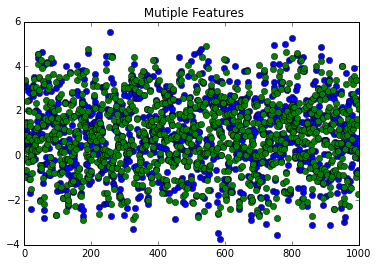

In [788]:
plt.plot(mY_Test,'o')
plt.plot(mY_cap_Test,'o')
plt.title(" Mutiple Features")
plt.show()

#Gaussian  Kernel Function

$K(X,Y) = e^{-||X-Y||^2/ 2\sigma^2}$

Where $ ||X-Y||^2 $ is the Euclidean distance between the vectors

In [789]:
def Gausian_Kernel(X,sigma):
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    K = np.exp(-(pairwise_dists ** 2 / sigma ** 2))
    return K

##Using the Gaussian  Kernel function we find  M X M matrix
where m is the number of data rows

We Find $\alpha = G^{-1} \cdot Y $

$ \theta = X^T \cdot \alpha $

$ \hat Y = \theta^T \cdot X $

In [790]:
start_time = timeit.default_timer()

G_Train =  Gausian_Kernel(mX_Train,np.std(mX_Train))
galpha = np.dot(np.linalg.inv(G_Train),mY_Train)
#predict - Alpha . X Transpose
dual_theta = np.dot(mX_Train.transpose(),galpha)
dual_Y_Cap =  predict(dual_theta,mX_Train)
dual_Y_Cap_Test = predict(dual_theta,mX_Test)

end_time = timeit.default_timer() 

gaussian_time = end_time --start_time 

In [791]:
print "Mean Squared Testing Error using Dual Solution (Gaussian Kernel function)",mean_squared_error(dual_Y_Cap_Test,mY_Test )
print "Time taken(Gaussian  Kernel) : ",end_time - start_time

print "Mean Squared Testing Error using Primal Solution ",mean_squared_error(mY_cap_Test,mY_Test )
print "Time Taken(Primal Solution) : ",implicit_time

Mean Squared Testing Error using Dual Solution (Gaussian Kernel function) 2.52663988549e+17
Time taken(Gaussian  Kernel) :  0.479422154178
Mean Squared Testing Error using Primal Solution  0.256139174876
Time Taken(Primal Solution) :  0.000984031408734


<i><b>From the mean square errors listed above we can see that Primal Solution has a better accuracy than Dual Solution.  This result can be justified, as Dual solution is more suited to the cases with less data and more features and Primal Solution for problems involving more data and lesser features.  </b></i>

## Iterative Solution Gradient Descent
$ \theta_i = \theta_{i-1} - \eta Z^T(Z\theta - Y) $  

In [792]:
def gradientDescent(x, y, theta, alpha, m, numIterations):
    xTrans = x.transpose()
    for i in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
           
        gradient = np.dot(xTrans, loss) / m
        theta = theta - alpha * gradient
    
    return theta

In [793]:

start_time = timeit.default_timer()

gd = gradientDescent(mZ,mY_Train,mtheta,0.4,len(Z),10)
gd_Y_cap = predict(gd,Z_test)

end_time = timeit.default_timer()


print "Mean Squared Testing Error using Gradient Descent",mean_squared_error(gd_Y_cap,mY_Test )
print "Time taken(Gradient Descent) : ",end_time - start_time
print "Mean Squared Testing Error using Primal Solution ",mean_squared_error(mY_cap_Test,mY_Test )
print "Time Taken(Primal Solution) : ",implicit_time


Mean Squared Testing Error using Gradient Descent 5.82964484198
Time taken(Gradient Descent) :  0.00133299691515
Mean Squared Testing Error using Primal Solution  0.256139174876
Time Taken(Primal Solution) :  0.000984031408734


##External Data Set


http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/


In [794]:
# External Data based regression 
def getdata_CSV(filename):
   
    return np.genfromtxt(filename,delimiter=",")

data1 = getdata_CSV("forestfires.csv")

print data1

[[   nan    nan    nan ...,    nan    nan    nan]
 [  7.     5.      nan ...,   6.7    0.     0.  ]
 [  7.     4.      nan ...,   0.9    0.     0.  ]
 ..., 
 [  7.     4.      nan ...,   6.7    0.    11.16]
 [  1.     4.      nan ...,   4.     0.     0.  ]
 [  6.     3.      nan ...,   4.5    0.     0.  ]]


In [795]:
X = data1[:,8:10]
Y = data1[:,12]

X = np.delete(X,0,axis=0)
Y = np.delete(Y,0,axis=0)

normalizedX = (X - np.mean(X))/np.var(X)

ext_Z =  X_to_Z(normalizedX,1)
etheta  = fit(ext_Z[:400],Y[:400])

ext_y_cap = predict(etheta,ext_Z[400:])


In [796]:

print "Mean Square Test Error ",mean_squared_error(ext_y_cap,Y[400:])


Mean Square Test Error  5630.39461509
